# Hybrid VAE-Transformer for Emotion-Aware Music Generation

This notebook implements a hybrid Variational Autoencoder (VAE) and Transformer model for generating emotion-aware music clips based on the EMOPIA and MAESTRO datasets.

## Project Overview
- **Dataset**: EMOPIA (emotion-labeled MIDI) + MAESTRO (piano MIDI)
- **Architecture**: VAE for latent representation + Transformer for emotion-conditioned generation
- **Emotions**: Q1 (High Valence, High Arousal), Q2 (Low Valence, High Arousal), Q3 (Low Valence, Low Arousal), Q4 (High Valence, Low Arousal)

## Model Architecture
1. **VAE Encoder**: Encodes MIDI sequences into latent space
2. **VAE Decoder**: Reconstructs sequences from latent space
3. **Transformer Decoder**: Generates music conditioned on emotion embeddings
4. **Hybrid Training**: Combines VAE reconstruction loss with Transformer generation loss


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random, os

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cpu


## 1. Data Loading and Preprocessing

### We'll load and preprocess MIDI files from both EMOPIA and MAESTRO datasets.


In [23]:
# Load EMOPIA metadata
emopia_label_path = 'EMOPIA_1.0/label.csv'
emopia_metadata_path = 'EMOPIA_1.0/metadata_by_song.csv'

try:
    emopia_labels = pd.read_csv(emopia_label_path)
    emopia_metadata = pd.read_csv(emopia_metadata_path)
    print("EMOPIA Dataset:")
    print(f"  - Label file: {len(emopia_labels)} samples")
    print(f"  - Metadata file: {len(emopia_metadata)} songs")
    print(f"  - Emotion distribution:\n{emopia_labels['4Q'].value_counts().sort_index()}")
except Exception as e:
    print(f"Error loading EMOPIA: {e}")
    emopia_labels = None
    emopia_metadata = None

# Load MAESTRO metadata
try:
    maestro_path = 'maestro-v3.0.0.csv'
    maestro_df = pd.read_csv(maestro_path)
    print(f"\nMAESTRO Dataset:")
    print(f"  - Total samples: {len(maestro_df)}")
    print(f"  - Split distribution:\n{maestro_df['split'].value_counts()}")
except Exception as e:
    print(f"Error loading MAESTRO: {e}")
    maestro_df = None


EMOPIA Dataset:
  - Label file: 1078 samples
  - Metadata file: 387 songs
  - Emotion distribution:
4Q
1    250
2    265
3    253
4    310
Name: count, dtype: int64

MAESTRO Dataset:
  - Total samples: 1276
  - Split distribution:
split
train         962
test          177
validation    137
Name: count, dtype: int64


In [24]:
# MIDI to Sequence Converter
# Converts MIDI files to sequences of (pitch, velocity, duration, time_offset)

def midi_to_sequence(midi_path, max_length=512, min_pitch=21, max_pitch=108):
    """
    Convert MIDI file to sequence of events.
    Returns: (sequence, valid) where sequence is numpy array of shape (seq_len, 4)
    Features: [pitch, velocity, duration, time_offset]
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        
        # Extract all notes from all instruments
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append({
                    'pitch': note.pitch,
                    'velocity': note.velocity,
                    'start': note.start,
                    'end': note.end,
                    'duration': note.end - note.start
                })
        
        if len(notes) == 0:
            return None, False
        
        # Sort by start time
        notes.sort(key=lambda x: x['start'])
        
        # Create sequence
        sequence = []
        prev_time = 0
        
        for note in notes[:max_length]:
            # Normalize features
            pitch = np.clip((note['pitch'] - min_pitch) / (max_pitch - min_pitch), 0, 1)
            velocity = note['velocity'] / 127.0
            duration = min(note['duration'], 4.0) / 4.0  # Cap duration at 4 seconds
            time_offset = min(note['start'] - prev_time, 2.0) / 2.0  # Cap time offset at 2 seconds
            
            sequence.append([pitch, velocity, duration, time_offset])
            prev_time = note['start']
        
        # Pad or truncate to max_length
        if len(sequence) < max_length:
            padding = [[0, 0, 0, 0]] * (max_length - len(sequence))
            sequence.extend(padding)
        else:
            sequence = sequence[:max_length]
        
        return np.array(sequence, dtype=np.float32), True
        
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None, False

# Test the conversion
test_midi = 'EMOPIA_1.0/midis/Q1_0vLPYiPN7qY_0.mid'
if os.path.exists(test_midi):
    seq, valid = midi_to_sequence(test_midi)
    if valid:
        print(f"Test conversion successful!")
        print(f"  - Sequence shape: {seq.shape}")
        print(f"  - Sample values: {seq[0]}")
    else:
        print("Test conversion failed")
else:
    print("Test MIDI file not found")


Test conversion successful!
  - Sequence shape: (512, 4)
  - Sample values: [0.4827586  0.511811   0.633138   0.09830729]


In [25]:
# ========== 2️⃣ CONFIGURATION ==========
config = {
    "latent_dim": 128,
    "hidden_dim": 256,
    "num_layers": 2,
    "vae_lr": 1e-4,
    "hybrid_lr": 2e-4,
    "vae_beta_start": 0.05,
    "vae_beta_end": 0.5,
    "vae_warmup_epochs": 30,
    "transformer_weight": 50,
    "dropout": 0.2,
    "batch_size": 32,
    "vae_epochs": 25,
    "hybrid_epochs": 20,
    "clip_grad": 1.0,
    "free_bits": 0.05,
}

In [5]:
# Create Dataset class
class MusicDataset(Dataset):
    def __init__(self, midi_files, emotions=None, max_length=512):
        """
        Args:
            midi_files: List of MIDI file paths
            emotions: List of emotion labels (Q1-Q4) or None for unlabeled data
            max_length: Maximum sequence length
        """
        self.midi_files = midi_files
        self.emotions = emotions
        self.max_length = max_length
        
    def __len__(self):
        return len(self.midi_files)
    
    def __getitem__(self, idx):
        midi_path = self.midi_files[idx]
        sequence, valid = midi_to_sequence(midi_path, self.max_length)
        
        if not valid:
            # Return zero sequence if invalid
            sequence = np.zeros((self.max_length, 4), dtype=np.float32)
        
        sequence = torch.FloatTensor(sequence)
        
        if self.emotions is not None:
            emotion = self.emotions[idx] - 1  # Convert Q1-Q4 to 0-3
            return sequence, torch.LongTensor([emotion])
        else:
            return sequence, torch.LongTensor([-1])  # No emotion label


In [6]:
# Load and prepare datasets
print("Loading EMOPIA dataset...")
emopia_midis = []
emopia_emotions = []

if emopia_labels is not None:
    emopia_midi_dir = Path('EMOPIA_1.0/midis')
    for idx, row in emopia_labels.iterrows():
        midi_file = emopia_midi_dir / f"{row['ID']}.mid"
        if midi_file.exists():
            emopia_midis.append(str(midi_file))
            emopia_emotions.append(row['4Q'])
    
    print(f"Loaded {len(emopia_midis)} EMOPIA MIDI files")

# Load MAESTRO dataset (unlabeled, for pre-training)
print("\nLoading MAESTRO dataset...")
maestro_midis = []
if maestro_df is not None:
    maestro_dir = Path('maestro-v3.0.0')
    # Use only training split to avoid data leakage
    train_df = maestro_df[maestro_df['split'] == 'train']
    for idx, row in train_df.iterrows():
        midi_file = maestro_dir / row['midi_filename']
        if midi_file.exists():
            maestro_midis.append(str(midi_file))
    
    print(f"Loaded {len(maestro_midis)} MAESTRO MIDI files")

# Limit dataset size for faster training (adjust as needed)
MAX_EMOPIA = min(500, len(emopia_midis))
MAX_MAESTRO = min(1000, len(maestro_midis))

emopia_midis = emopia_midis[:MAX_EMOPIA]
emopia_emotions = emopia_emotions[:MAX_EMOPIA]
maestro_midis = maestro_midis[:MAX_MAESTRO]

print(f"\nFinal dataset sizes:")
print(f"  - EMOPIA (labeled): {len(emopia_midis)}")
print(f"  - MAESTRO (unlabeled): {len(maestro_midis)}")


Loading EMOPIA dataset...
Loaded 1078 EMOPIA MIDI files

Loading MAESTRO dataset...
Loaded 962 MAESTRO MIDI files

Final dataset sizes:
  - EMOPIA (labeled): 500
  - MAESTRO (unlabeled): 962


## 2. Model Architecture

We'll build:
1. **VAE Encoder**: Encodes sequences to latent space
2. **VAE Decoder**: Reconstructs sequences from latent space
3. **Transformer Decoder**: Generates sequences conditioned on emotion
4. **Hybrid Model**: Combines VAE and Transformer


In [ ]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256, latent_dim=128, num_layers=2):
        super(VAEEncoder, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        h_forward = h_n[-2]  # (batch_size, hidden_dim)
        h_backward = h_n[-1]  # (batch_size, hidden_dim)
        
        # Concatenate forward and backward hidden states
        h_concat = torch.cat([h_forward, h_backward], dim=1)  # (batch_size, hidden_dim * 2)
        
        mu = self.fc_mu(h_concat)
        logvar = self.fc_logvar(h_concat)
        
        return mu, logvar

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=128, hidden_dim=256, output_dim=4, num_layers=2, seq_len=512):
        super(VAEDecoder, self).__init__()
        
        self.seq_len = seq_len
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        # z: (batch_size, latent_dim)
        batch_size = z.size(0)
        
        # Expand latent vector
        h = self.fc(z).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        h = h.repeat(1, self.seq_len, 1)  # (batch_size, seq_len, hidden_dim)
        
        # LSTM decoding
        lstm_out, _ = self.lstm(h)
        
        # Output layer
        output = self.fc_out(lstm_out)  # (batch_size, seq_len, output_dim)
        
        return output

# Emotion Embedding
class EmotionEmbedding(nn.Module):
    def __init__(self, num_emotions=4, embedding_dim=128):
        super(EmotionEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_emotions, embedding_dim)
        
    def forward(self, emotion_ids):
        # emotion_ids: (batch_size,)
        return self.embedding(emotion_ids)  # (batch_size, embedding_dim)

# Transformer Decoder for Music Generation
class MusicTransformerDecoder(nn.Module):
    def __init__(self, input_dim=4, d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, max_seq_len=512):
        super(MusicTransformerDecoder, self).__init__()
        
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(max_seq_len, d_model))
        
        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, input_dim)
        
    def forward(self, tgt, memory):
        # tgt: (batch_size, seq_len, input_dim) - previous sequence
        # memory: (batch_size, latent_dim) - latent representation + emotion embedding
        batch_size, seq_len, _ = tgt.shape
        
        # Project input
        tgt_embed = self.input_projection(tgt)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        tgt_embed = tgt_embed + self.pos_encoder[:seq_len].unsqueeze(0)
        
        # Expand memory for transformer (batch_size, 1, d_model)
        memory_expanded = memory.unsqueeze(1)
        
        # Create causal mask for autoregressive generation
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(tgt.device)
        
        # Transformer decoder
        output = self.transformer_decoder(tgt_embed, memory_expanded, tgt_mask=mask)
        
        # Output projection
        output = self.output_projection(output)
        
        return output

# Hybrid VAE-
# 
# 
# 
#  Model
class HybridVAETransformer(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256, latent_dim=128, 
                 d_model=256, nhead=8, num_transformer_layers=4,
                 num_lstm_layers=2, seq_len=512, num_emotions=4):
        super(HybridVAETransformer, self).__init__()
        
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        # VAE components
        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim, num_lstm_layers)
        self.decoder = VAEDecoder(latent_dim, hidden_dim, input_dim, num_lstm_layers, seq_len)
        
        # Emotion embedding
        self.emotion_embedding = EmotionEmbedding(num_emotions, latent_dim)
        
        # Transformer decoder
        self.transformer_decoder = MusicTransformerDecoder(
            input_dim, d_model, nhead, num_transformer_layers, 
            dim_feedforward=hidden_dim*4, max_seq_len=seq_len
        )
        
        # Projection layer to combine latent and emotion
        self.latent_projection = nn.Linear(latent_dim * 2, d_model)
        
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        """Encode sequence to latent space"""
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode_vae(self, z):
        """Decode from latent space (VAE reconstruction)"""
        return self.decoder(z)
    
    def generate_transformer(self, z, emotion_ids, tgt=None):
        """Generate sequence using transformer conditioned on emotion"""
        # Get emotion embedding
        emotion_emb = self.emotion_embedding(emotion_ids)  # (batch_size, latent_dim)
        
        # Combine latent and emotion
        combined = torch.cat([z, emotion_emb], dim=1)  # (batch_size, latent_dim * 2)
        memory = self.latent_projection(combined)  # (batch_size, d_model)
        
        # Use previous sequence or zeros as target
        if tgt is None:
            batch_size = z.size(0)
            tgt = torch.zeros(batch_size, self.seq_len, 4).to(z.device)
        
        # Generate with transformer
        output = self.transformer_decoder(tgt, memory)
        
        return output
    
    def forward(self, x, emotion_ids=None, use_vae=True, use_transformer=True):
        """
        Forward pass
        Args:
            x: Input sequence (batch_size, seq_len, input_dim)
            emotion_ids: Emotion labels (batch_size,) or None
            use_vae: Whether to use VAE reconstruction
            use_transformer: Whether to use transformer generation
        """
        outputs = {}
        
        # Encode to latent space
        z, mu, logvar = self.encode(x)
        outputs['z'] = z
        outputs['mu'] = mu
        outputs['logvar'] = logvar
        
        # VAE reconstruction
        if use_vae:
            recon = self.decode_vae(z)
            outputs['recon'] = recon
        
        # Transformer generation (if emotion provided)
        if use_transformer and emotion_ids is not None:
            trans_output = self.generate_transformer(z, emotion_ids, x)
            outputs['transformer_output'] = trans_output
        
        return outputs

# Create model instance
model = HybridVAETransformer(
    input_dim=4,
    hidden_dim=256,
    latent_dim=128,
    d_model=256,
    nhead=8,
    num_transformer_layers=4,
    num_lstm_layers=2,
    seq_len=512,
    num_emotions=4
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Model architecture:")
print(model)


Model created with 7745032 parameters
Model architecture:
HybridVAETransformer(
  (encoder): VAEEncoder(
    (lstm): LSTM(4, 256, num_layers=2, batch_first=True, bidirectional=True)
    (fc_mu): Linear(in_features=512, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): VAEDecoder(
    (fc): Linear(in_features=128, out_features=256, bias=True)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
    (fc_out): Linear(in_features=256, out_features=4, bias=True)
  )
  (emotion_embedding): EmotionEmbedding(
    (embedding): Embedding(4, 128)
  )
  (transformer_decoder): MusicTransformerDecoder(
    (input_projection): Linear(in_features=4, out_features=256, bias=True)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias

## 3. Training Setup

We'll train the model in two phases:
1. **Pre-training on MAESTRO**: Train VAE on unlabeled data
2. **Fine-tuning on EMOPIA**: Train hybrid model with emotion conditioning


In [8]:
# Loss functions with improved parameters
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss: reconstruction + KL divergence
    
    Args:
        beta: KL loss weight (β-VAE parameter). Higher values encourage 
              more disentangled latent representations.
    """
    # Reconstruction loss (MSE) - normalized by batch size
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    
    # KL divergence loss (normalized by batch size)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

def transformer_loss(pred, target):
    """Transformer generation loss (MSE)"""
    return F.mse_loss(pred, target, reduction='mean')

# Create data loaders
batch_size = 16

# EMOPIA dataset (labeled)
if len(emopia_midis) > 0:
    emopia_dataset = MusicDataset(emopia_midis, emopia_emotions, max_length=512)
    emopia_loader = DataLoader(emopia_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
else:
    emopia_loader = None

# MAESTRO dataset (unlabeled)
if len(maestro_midis) > 0:
    maestro_dataset = MusicDataset(maestro_midis, None, max_length=512)
    maestro_loader = DataLoader(maestro_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
else:
    maestro_loader = None

# Training hyperparameters (improved based on analysis)
VAE_PRETRAIN_EPOCHS = 25  # Increased from 5 to ensure proper latent space formation
VAE_BETA = 0.3  # Increased from 0.1 to encourage better latent representations
HYBRID_EPOCHS = 20  # Increased from 15
TRANSFORMER_LOSS_WEIGHT = 10.0  # Weight to balance transformer loss with VAE loss

# Learning rates (different for different phases)
VAE_LR = 0.0001  # Lower LR for VAE pre-training (more stable)
HYBRID_LR = 0.0002  # Slightly higher LR for hybrid phase

# Optimizers will be created separately for each phase
print("Training setup complete!")
print(f"  VAE Pre-training: {VAE_PRETRAIN_EPOCHS} epochs, beta={VAE_BETA}, LR={VAE_LR}")
print(f"  Hybrid Training: {HYBRID_EPOCHS} epochs, Transformer weight={TRANSFORMER_LOSS_WEIGHT}, LR={HYBRID_LR}")


Training setup complete!
  VAE Pre-training: 25 epochs, beta=0.3, LR=0.0001
  Hybrid Training: 20 epochs, Transformer weight=10.0, LR=0.0002


In [9]:
# Phase 1: Pre-train VAE on MAESTRO (unlabeled data)
def train_vae_phase(model, dataloader, num_epochs=25, beta=0.3, lr=0.0001):
    """Pre-train VAE on unlabeled data with improved hyperparameters
    
    Args:
        num_epochs: Number of training epochs (increased for better convergence)
        beta: KL loss weight (increased to prevent KL collapse)
        lr: Learning rate for VAE pre-training
    """
    model.train()
    losses = []
    
    # Create optimizer for VAE phase
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        recon_losses = 0
        kl_losses = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for sequences, _ in pbar:
            sequences = sequences.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass (VAE only)
            outputs = model(sequences, use_vae=True, use_transformer=False)
            
            # Calculate loss with improved beta
            loss, recon_loss, kl_loss = vae_loss(
                outputs['recon'], sequences, 
                outputs['mu'], outputs['logvar'], 
                beta=beta  # Increased beta to encourage better latent space
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            recon_losses += recon_loss.item()
            kl_losses += kl_loss.item()
            
            pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item(),
                'beta': beta
            })
        
        avg_loss = epoch_loss / len(dataloader)
        avg_recon = recon_losses / len(dataloader)
        avg_kl = kl_losses / len(dataloader)
        
        losses.append({'total': avg_loss, 'recon': avg_recon, 'kl': avg_kl})
        scheduler.step(avg_loss)
        
        # Print KL/Recon ratio to monitor KL collapse
        kl_recon_ratio = avg_kl / (avg_recon + 1e-8)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Recon={avg_recon:.4f}, KL={avg_kl:.4f}, KL/Recon={kl_recon_ratio:.4f}")
    
    return losses

# Function to inspect reconstruction quality
def inspect_reconstructions(model, dataloader, num_samples=3):
    """Inspect reconstruction quality to detect KL collapse"""
    model.eval()
    samples = []
    
    with torch.no_grad():
        for i, (sequences, _) in enumerate(dataloader):
            if i >= num_samples:
                break
            sequences = sequences.to(device)
            outputs = model(sequences, use_vae=True, use_transformer=False)
            
            # Get original and reconstructed
            original = sequences[0].cpu().numpy()
            reconstructed = outputs['recon'][0].cpu().numpy()
            
            # Calculate statistics
            mse = np.mean((original - reconstructed) ** 2)
            
            samples.append({
                'original': original,
                'reconstructed': reconstructed,
                'mse': mse,
                'mu': outputs['mu'][0].cpu().numpy(),
                'logvar': outputs['logvar'][0].cpu().numpy()
            })
    
    model.train()
    return samples

# Run pre-training if MAESTRO data is available
if maestro_loader is not None:
    print("Phase 1: Pre-training VAE on MAESTRO dataset...")
    print(f"  Epochs: {VAE_PRETRAIN_EPOCHS}, Beta: {VAE_BETA}, Learning Rate: {VAE_LR}")
    vae_losses = train_vae_phase(model, maestro_loader, num_epochs=VAE_PRETRAIN_EPOCHS, 
                                   beta=VAE_BETA, lr=VAE_LR)
    print("VAE pre-training complete!")
    
    # Inspect reconstruction quality
    print("\nInspecting reconstruction quality...")
    recon_samples = inspect_reconstructions(model, maestro_loader, num_samples=3)
    for i, sample in enumerate(recon_samples):
        print(f"  Sample {i+1}: MSE={sample['mse']:.4f}, "
              f"Latent std={np.std(sample['mu']):.4f}")
else:
    print("Skipping VAE pre-training (no MAESTRO data)")


Phase 1: Pre-training VAE on MAESTRO dataset...
  Epochs: 25, Beta: 0.3, Learning Rate: 0.0001


Epoch 1/25: 100%|██████████| 61/61 [01:57<00:00,  1.93s/it, loss=0.0193, recon=0.0173, kl=0.00662, beta=0.3] 


Epoch 1: Loss=0.0616, Recon=0.0593, KL=0.0078, KL/Recon=0.1319


Epoch 2/25: 100%|██████████| 61/61 [01:56<00:00,  1.91s/it, loss=0.0199, recon=0.0192, kl=0.00223, beta=0.3]


Epoch 2: Loss=0.0206, Recon=0.0193, KL=0.0045, KL/Recon=0.2328


Epoch 3/25: 100%|██████████| 61/61 [01:56<00:00,  1.91s/it, loss=0.0305, recon=0.0303, kl=0.000497, beta=0.3]


Epoch 3: Loss=0.0182, Recon=0.0179, KL=0.0012, KL/Recon=0.0652


Epoch 4/25: 100%|██████████| 61/61 [01:56<00:00,  1.92s/it, loss=0.0244, recon=0.0244, kl=8.96e-5, beta=0.3] 


Epoch 4: Loss=0.0176, Recon=0.0176, KL=0.0002, KL/Recon=0.0138


Epoch 5/25: 100%|██████████| 61/61 [01:57<00:00,  1.93s/it, loss=0.0134, recon=0.0134, kl=2.24e-5, beta=0.3]


Epoch 5: Loss=0.0173, Recon=0.0172, KL=0.0000, KL/Recon=0.0028


Epoch 6/25: 100%|██████████| 61/61 [01:57<00:00,  1.93s/it, loss=0.0106, recon=0.0106, kl=1.38e-5, beta=0.3]


Epoch 6: Loss=0.0172, Recon=0.0172, KL=0.0000, KL/Recon=0.0011


Epoch 7/25: 100%|██████████| 61/61 [01:58<00:00,  1.94s/it, loss=0.0212, recon=0.0212, kl=9.97e-6, beta=0.3]


Epoch 7: Loss=0.0173, Recon=0.0173, KL=0.0000, KL/Recon=0.0007


Epoch 8/25: 100%|██████████| 61/61 [01:58<00:00,  1.93s/it, loss=0.0146, recon=0.0146, kl=8.69e-6, beta=0.3]


Epoch 8: Loss=0.0171, Recon=0.0171, KL=0.0000, KL/Recon=0.0005


Epoch 9/25: 100%|██████████| 61/61 [01:56<00:00,  1.92s/it, loss=0.0202, recon=0.0202, kl=6.63e-6, beta=0.3]


Epoch 9: Loss=0.0171, Recon=0.0171, KL=0.0000, KL/Recon=0.0004


Epoch 10/25: 100%|██████████| 61/61 [01:57<00:00,  1.92s/it, loss=0.0145, recon=0.0145, kl=9.45e-6, beta=0.3]


Epoch 10: Loss=0.0171, Recon=0.0171, KL=0.0000, KL/Recon=0.0004


Epoch 11/25: 100%|██████████| 61/61 [01:56<00:00,  1.91s/it, loss=0.0157, recon=0.0157, kl=4.34e-6, beta=0.3]


Epoch 11: Loss=0.0171, Recon=0.0171, KL=0.0000, KL/Recon=0.0004


Epoch 12/25: 100%|██████████| 61/61 [01:56<00:00,  1.90s/it, loss=0.0149, recon=0.0149, kl=4.34e-6, beta=0.3]


Epoch 12: Loss=0.0171, Recon=0.0171, KL=0.0000, KL/Recon=0.0003


Epoch 13/25: 100%|██████████| 61/61 [01:58<00:00,  1.93s/it, loss=0.0126, recon=0.0126, kl=3.37e-6, beta=0.3]


Epoch 13: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0003


Epoch 14/25: 100%|██████████| 61/61 [02:00<00:00,  1.98s/it, loss=0.0161, recon=0.0161, kl=3.21e-6, beta=0.3]


Epoch 14: Loss=0.0170, Recon=0.0170, KL=0.0000, KL/Recon=0.0002


Epoch 15/25: 100%|██████████| 61/61 [02:01<00:00,  1.99s/it, loss=0.0139, recon=0.0139, kl=3.39e-6, beta=0.3]


Epoch 15: Loss=0.0170, Recon=0.0170, KL=0.0000, KL/Recon=0.0003


Epoch 16/25: 100%|██████████| 61/61 [02:00<00:00,  1.98s/it, loss=0.0149, recon=0.0149, kl=3.1e-6, beta=0.3] 


Epoch 16: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 17/25: 100%|██████████| 61/61 [01:58<00:00,  1.94s/it, loss=0.0143, recon=0.0143, kl=2.95e-6, beta=0.3]


Epoch 17: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 18/25: 100%|██████████| 61/61 [01:56<00:00,  1.91s/it, loss=0.0108, recon=0.0108, kl=3.24e-6, beta=0.3]


Epoch 18: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 19/25: 100%|██████████| 61/61 [02:00<00:00,  1.98s/it, loss=0.0119, recon=0.0119, kl=3.45e-6, beta=0.3]


Epoch 19: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 20/25: 100%|██████████| 61/61 [02:00<00:00,  1.98s/it, loss=0.0196, recon=0.0196, kl=2.35e-6, beta=0.3]


Epoch 20: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 21/25: 100%|██████████| 61/61 [02:00<00:00,  1.97s/it, loss=0.0223, recon=0.0223, kl=2.83e-6, beta=0.3]


Epoch 21: Loss=0.0170, Recon=0.0170, KL=0.0000, KL/Recon=0.0002


Epoch 22/25: 100%|██████████| 61/61 [01:59<00:00,  1.96s/it, loss=0.0158, recon=0.0158, kl=2.35e-6, beta=0.3]


Epoch 22: Loss=0.0169, Recon=0.0169, KL=0.0000, KL/Recon=0.0002


Epoch 23/25: 100%|██████████| 61/61 [02:00<00:00,  1.98s/it, loss=0.0145, recon=0.0145, kl=2.04e-6, beta=0.3]


Epoch 23: Loss=0.0168, Recon=0.0168, KL=0.0000, KL/Recon=0.0001


Epoch 24/25: 100%|██████████| 61/61 [02:00<00:00,  1.97s/it, loss=0.0286, recon=0.0286, kl=1.66e-6, beta=0.3]


Epoch 24: Loss=0.0170, Recon=0.0170, KL=0.0000, KL/Recon=0.0001


Epoch 25/25: 100%|██████████| 61/61 [02:00<00:00,  1.97s/it, loss=0.0269, recon=0.0269, kl=1.49e-6, beta=0.3]


Epoch 25: Loss=0.0170, Recon=0.0170, KL=0.0000, KL/Recon=0.0001
VAE pre-training complete!

Inspecting reconstruction quality...
  Sample 1: MSE=0.0143, Latent std=0.0015
  Sample 2: MSE=0.0203, Latent std=0.0016
  Sample 3: MSE=0.0297, Latent std=0.0015


In [ ]:
# Phase 2: Fine-tune hybrid model on EMOPIA (with emotion labels)
def train_hybrid_phase(model, dataloader, num_epochs=20, beta=0.3, 
                       transformer_weight=10.0, lr=0.0002):
    """Train hybrid VAE-Transformer model with emotion conditioning
    
    Args:
        num_epochs: Number of training epochs
        beta: KL loss weight for VAE component
        transformer_weight: Weight for transformer loss (to balance with VAE loss)
        lr: Learning rate for hybrid phase
    """
    model.train() 
    losses = []
    
    # Create optimizer for hybrid phase with different learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        vae_losses_epoch = 0
        trans_losses_epoch = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for sequences, emotions in pbar:
            sequences = sequences.to(device)
            emotions = emotions.squeeze().to(device)
            
            optimizer.zero_grad()
            
            # Forward pass (both VAE and Transformer)
            outputs = model(sequences, emotion_ids=emotions, use_vae=True, use_transformer=True)
            
            # VAE loss with improved beta
            vae_loss_val, recon_loss, kl_loss = vae_loss(
                outputs['recon'], sequences,
                outputs['mu'], outputs['logvar'],
                beta=beta
            )
            
            # Transformer loss (compare transformer output to input)
            trans_loss_val = transformer_loss(outputs['transformer_output'], sequences)
            
            # Combined loss with rebalanced weights
            # Normalize and weight transformer loss to balance with VAE loss
            total_loss = vae_loss_val + transformer_weight * trans_loss_val
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            vae_losses_epoch += vae_loss_val.item()
            trans_losses_epoch += trans_loss_val.item()
            
            pbar.set_postfix({
                'total': total_loss.item(),
                'vae': vae_loss_val.item(),
                'trans': trans_loss_val.item(),
                'trans_w': transformer_weight
            })
        
        avg_loss = epoch_loss / len(dataloader)
        avg_vae = vae_losses_epoch / len(dataloader)
        avg_trans = trans_losses_epoch / len(dataloader)
        
        losses.append({'total': avg_loss, 'vae': avg_vae, 'transformer': avg_trans})
        scheduler.step(avg_loss)
        
        # Print loss ratio to monitor balance
        trans_vae_ratio = (transformer_weight * avg_trans) / (avg_vae + 1e-8)
        print(f"Epoch {epoch+1}: Total={avg_loss:.4f}, VAE={avg_vae:.4f}, "
              f"Transformer={avg_trans:.4f}, Weighted_Trans/VAE={trans_vae_ratio:.4f}")
    
    return losses

# Run fine-tuning if EMOPIA data is available
if emopia_loader is not None:
    print("\nPhase 2: Fine-tuning hybrid model on EMOPIA dataset...")
    print(f"  Epochs: {HYBRID_EPOCHS}, Beta: {VAE_BETA}, Transformer Weight: {TRANSFORMER_LOSS_WEIGHT}, LR: {HYBRID_LR}")
    hybrid_losses = train_hybrid_phase(model, emopia_loader, 
                                       num_epochs=HYBRID_EPOCHS,
                                       beta=VAE_BETA,
                                       transformer_weight=TRANSFORMER_LOSS_WEIGHT,
                                       lr=HYBRID_LR)
    print("Hybrid model training complete!")
else:
    print("Skipping hybrid training (no EMOPIA data)")



Phase 2: Fine-tuning hybrid model on EMOPIA dataset...
  Epochs: 20, Beta: 0.3, Transformer Weight: 10.0, LR: 0.0002


Epoch 1/20: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it, total=0.529, vae=0.0503, trans=0.0478, trans_w=10]


Epoch 1: Total=1.3473, VAE=0.0503, Transformer=0.1297, Weighted_Trans/VAE=25.7848


Epoch 2/20: 100%|██████████| 32/32 [00:54<00:00,  1.70s/it, total=0.332, vae=0.0659, trans=0.0266, trans_w=10]


Epoch 2: Total=0.4117, VAE=0.0500, Transformer=0.0362, Weighted_Trans/VAE=7.2350


Epoch 3/20: 100%|██████████| 32/32 [00:55<00:00,  1.73s/it, total=0.227, vae=0.0501, trans=0.0177, trans_w=10]


Epoch 3: Total=0.2600, VAE=0.0496, Transformer=0.0210, Weighted_Trans/VAE=4.2427


Epoch 4/20: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it, total=0.249, vae=0.0577, trans=0.0191, trans_w=10]


Epoch 4: Total=0.2113, VAE=0.0496, Transformer=0.0162, Weighted_Trans/VAE=3.2607


Epoch 5/20: 100%|██████████| 32/32 [00:55<00:00,  1.72s/it, total=0.192, vae=0.0494, trans=0.0142, trans_w=10] 


Epoch 5: Total=0.1768, VAE=0.0496, Transformer=0.0127, Weighted_Trans/VAE=2.5667


Epoch 6/20: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it, total=0.131, vae=0.0445, trans=0.00866, trans_w=10]


Epoch 6: Total=0.1586, VAE=0.0495, Transformer=0.0109, Weighted_Trans/VAE=2.2022


Epoch 7/20: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it, total=0.121, vae=0.0537, trans=0.0067, trans_w=10] 


Epoch 7: Total=0.1329, VAE=0.0497, Transformer=0.0083, Weighted_Trans/VAE=1.6735


Epoch 8/20: 100%|██████████| 32/32 [00:55<00:00,  1.72s/it, total=0.124, vae=0.0555, trans=0.00686, trans_w=10]


Epoch 8: Total=0.1271, VAE=0.0495, Transformer=0.0078, Weighted_Trans/VAE=1.5652


Epoch 9/20: 100%|██████████| 32/32 [00:57<00:00,  1.80s/it, total=0.1, vae=0.0437, trans=0.00563, trans_w=10]   


Epoch 9: Total=0.1099, VAE=0.0491, Transformer=0.0061, Weighted_Trans/VAE=1.2367


Epoch 10/20: 100%|██████████| 32/32 [00:55<00:00,  1.75s/it, total=0.136, vae=0.054, trans=0.00818, trans_w=10]  


Epoch 10: Total=0.0988, VAE=0.0491, Transformer=0.0050, Weighted_Trans/VAE=1.0135


Epoch 11/20: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it, total=0.125, vae=0.0404, trans=0.00849, trans_w=10] 


Epoch 11: Total=0.1098, VAE=0.0489, Transformer=0.0061, Weighted_Trans/VAE=1.2479


Epoch 12/20: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it, total=0.0756, vae=0.0452, trans=0.00304, trans_w=10]


Epoch 12: Total=0.0937, VAE=0.0491, Transformer=0.0045, Weighted_Trans/VAE=0.9101


Epoch 13/20: 100%|██████████| 32/32 [00:56<00:00,  1.76s/it, total=0.0948, vae=0.0546, trans=0.00402, trans_w=10]


Epoch 13: Total=0.0877, VAE=0.0493, Transformer=0.0038, Weighted_Trans/VAE=0.7806


Epoch 14/20: 100%|██████████| 32/32 [00:55<00:00,  1.75s/it, total=0.0684, vae=0.0318, trans=0.00366, trans_w=10]


Epoch 14: Total=0.0873, VAE=0.0486, Transformer=0.0039, Weighted_Trans/VAE=0.7957


Epoch 15/20: 100%|██████████| 32/32 [00:54<00:00,  1.69s/it, total=0.0773, vae=0.0478, trans=0.00295, trans_w=10]


Epoch 15: Total=0.0828, VAE=0.0488, Transformer=0.0034, Weighted_Trans/VAE=0.6986


Epoch 16/20: 100%|██████████| 32/32 [00:57<00:00,  1.79s/it, total=0.081, vae=0.0547, trans=0.00263, trans_w=10] 


Epoch 16: Total=0.0779, VAE=0.0490, Transformer=0.0029, Weighted_Trans/VAE=0.5888


Epoch 17/20: 100%|██████████| 32/32 [00:57<00:00,  1.80s/it, total=0.0662, vae=0.0372, trans=0.00289, trans_w=10]


Epoch 17: Total=0.0773, VAE=0.0489, Transformer=0.0028, Weighted_Trans/VAE=0.5813


Epoch 18/20: 100%|██████████| 32/32 [00:58<00:00,  1.82s/it, total=0.0806, vae=0.0597, trans=0.00209, trans_w=10]


Epoch 18: Total=0.0736, VAE=0.0488, Transformer=0.0025, Weighted_Trans/VAE=0.5076


Epoch 19/20: 100%|██████████| 32/32 [00:57<00:00,  1.79s/it, total=0.0681, vae=0.0425, trans=0.00256, trans_w=10]


Epoch 19: Total=0.0713, VAE=0.0489, Transformer=0.0022, Weighted_Trans/VAE=0.4586


Epoch 20/20: 100%|██████████| 32/32 [00:58<00:00,  1.83s/it, total=0.0689, vae=0.0457, trans=0.00231, trans_w=10]

Epoch 20: Total=0.0719, VAE=0.0488, Transformer=0.0023, Weighted_Trans/VAE=0.4739
Hybrid model training complete!


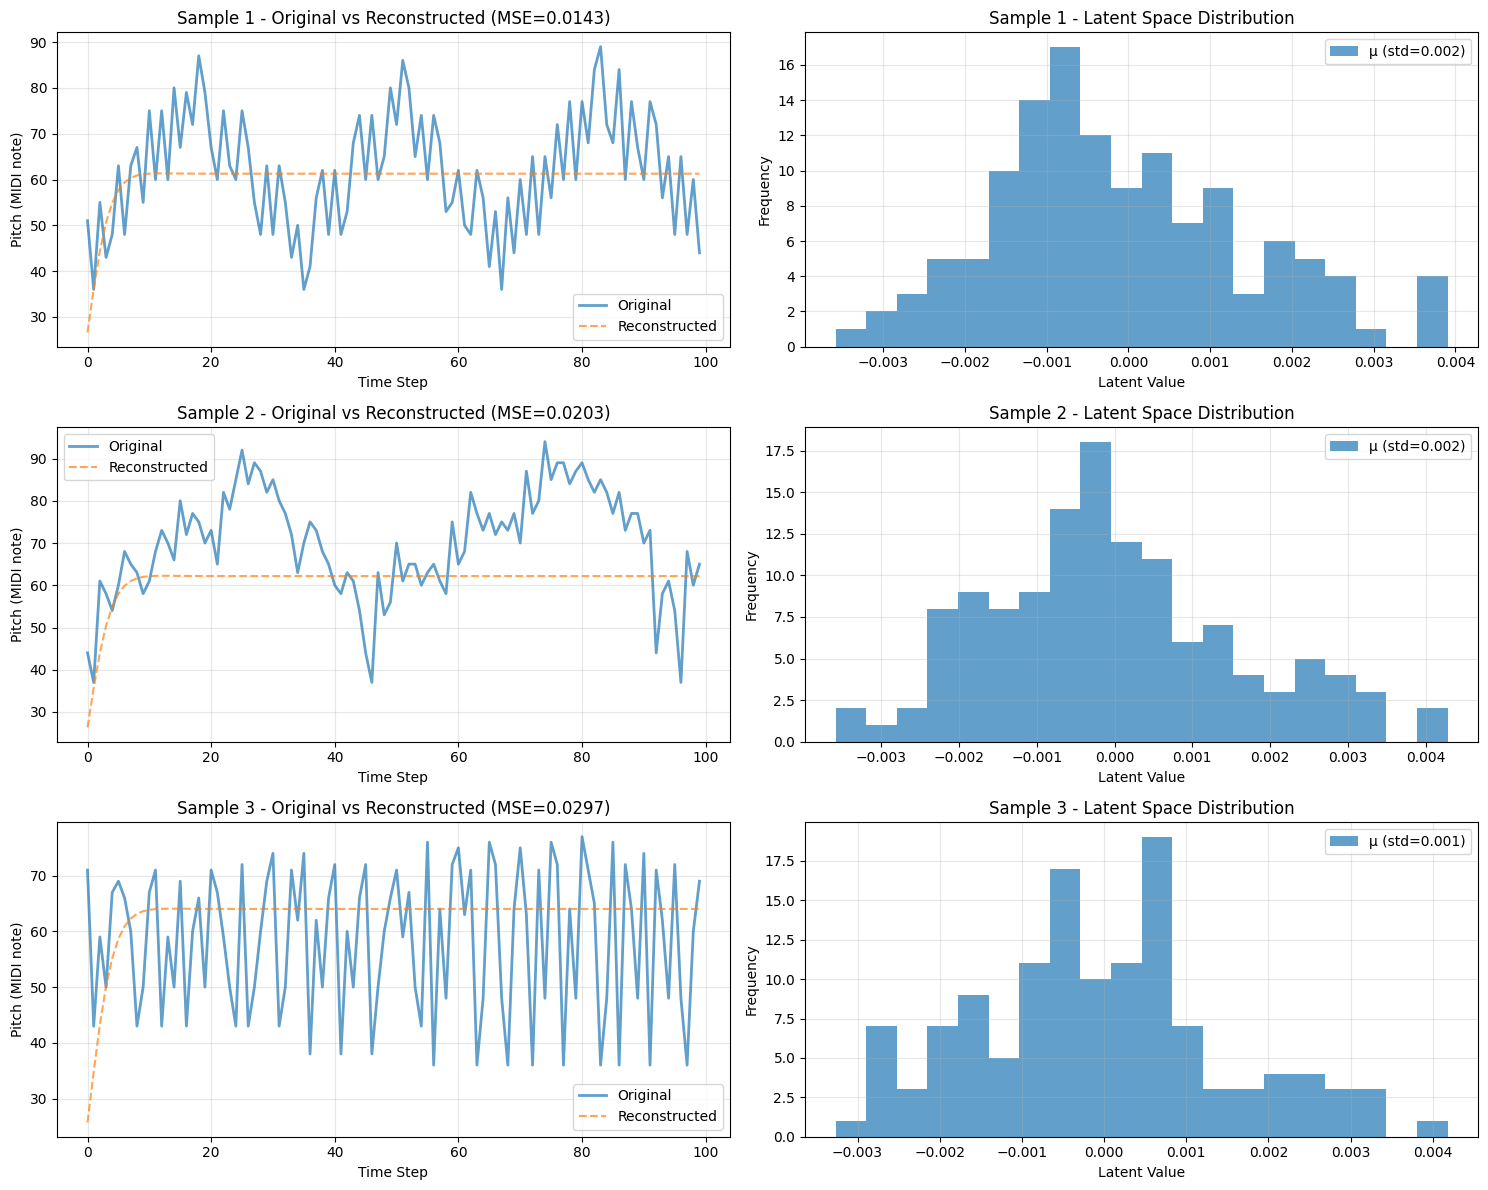


KL Collapse Detection:
  Average Latent Std: 0.0015
  ⚠️  WARNING: Low latent std detected! Possible KL collapse.
  → Consider increasing beta value further


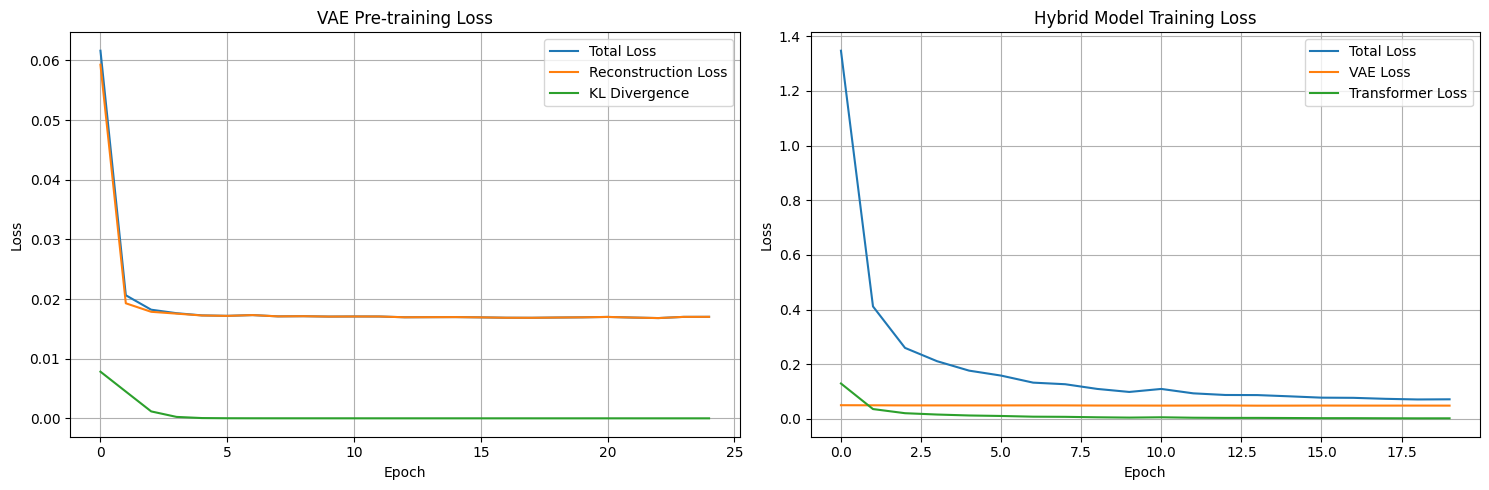

In [11]:
# Visualize reconstruction samples to detect KL collapse
if 'recon_samples' in locals() and len(recon_samples) > 0:
    fig, axes = plt.subplots(len(recon_samples), 2, figsize=(15, 4*len(recon_samples)))
    if len(recon_samples) == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(recon_samples):
        # Plot original sequence (first 100 notes - pitch only)
        orig_pitch = sample['original'][:100, 0] * 87 + 21
        recon_pitch = sample['reconstructed'][:100, 0] * 87 + 21
        
        axes[i, 0].plot(orig_pitch, label='Original', alpha=0.7, linewidth=2)
        axes[i, 0].plot(recon_pitch, label='Reconstructed', alpha=0.7, linestyle='--')
        axes[i, 0].set_title(f'Sample {i+1} - Original vs Reconstructed (MSE={sample["mse"]:.4f})')
        axes[i, 0].set_xlabel('Time Step')
        axes[i, 0].set_ylabel('Pitch (MIDI note)')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot latent space statistics
        axes[i, 1].hist(sample['mu'], bins=20, alpha=0.7, label=f'μ (std={np.std(sample["mu"]):.3f})')
        axes[i, 1].set_title(f'Sample {i+1} - Latent Space Distribution')
        axes[i, 1].set_xlabel('Latent Value')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check for KL collapse indicators
    avg_latent_std = np.mean([np.std(s['mu']) for s in recon_samples])
    print(f"\nKL Collapse Detection:")
    print(f"  Average Latent Std: {avg_latent_std:.4f}")
    if avg_latent_std < 0.1:
        print("  ⚠️  WARNING: Low latent std detected! Possible KL collapse.")
        print("  → Consider increasing beta value further")
    else:
        print("  ✓ Latent space appears to be utilized (std > 0.1)")

# Plot training losses
if 'vae_losses' in locals() or 'hybrid_losses' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    if 'vae_losses' in locals():
        vae_df = pd.DataFrame(vae_losses)
        axes[0].plot(vae_df['total'], label='Total Loss')
        axes[0].plot(vae_df['recon'], label='Reconstruction Loss')
        axes[0].plot(vae_df['kl'], label='KL Divergence')
        axes[0].set_title('VAE Pre-training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
    
    if 'hybrid_losses' in locals():
        hybrid_df = pd.DataFrame(hybrid_losses)
        axes[1].plot(hybrid_df['total'], label='Total Loss')
        axes[1].plot(hybrid_df['vae'], label='VAE Loss')
        axes[1].plot(hybrid_df['transformer'], label='Transformer Loss')
        axes[1].set_title('Hybrid Model Training Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


## 4. Music Generation

Generate music sequences conditioned on emotions.


In [12]:
# Music Generation Function
def generate_music(model, emotion_id, seq_length=512, temperature=1.0):
    """
    Generate music sequence conditioned on emotion.
    
    Args:
        model: Trained hybrid model
        emotion_id: Emotion label (1-4 for Q1-Q4)
        seq_length: Length of generated sequence
        temperature: Sampling temperature (higher = more random)
    
    Returns:
        Generated sequence as numpy array
    """
    model.eval()
    
    with torch.no_grad():
        # Create random latent vector
        z = torch.randn(1, model.latent_dim).to(device)
        
        # Create emotion tensor
        emotion = torch.LongTensor([emotion_id - 1]).to(device)  # Convert to 0-3
        
        # Generate sequence using transformer
        tgt = torch.zeros(1, seq_length, 4).to(device)
        generated = model.generate_transformer(z, emotion, tgt)
        
        # Apply temperature
        generated = generated / temperature
        
        # Convert to numpy
        sequence = generated.cpu().numpy()[0]
        
        return sequence

# Test generation for each emotion
emotion_names = {1: 'Q1 (High Valence, High Arousal)',
                 2: 'Q2 (Low Valence, High Arousal)',
                 3: 'Q3 (Low Valence, Low Arousal)',
                 4: 'Q4 (High Valence, Low Arousal)'}

print("Generating sample music for each emotion...")
generated_samples = {}

for emotion_id in range(1, 5):
    print(f"\nGenerating music for {emotion_names[emotion_id]}...")
    sequence = generate_music(model, emotion_id, seq_length=512, temperature=1.0)
    generated_samples[emotion_id] = sequence
    print(f"Generated sequence shape: {sequence.shape}")
    print(f"Sample values: pitch={sequence[0, 0]:.3f}, velocity={sequence[0, 1]:.3f}, "
          f"duration={sequence[0, 2]:.3f}, time_offset={sequence[0, 3]:.3f}")


Generating sample music for each emotion...

Generating music for Q1 (High Valence, High Arousal)...
Generated sequence shape: (512, 4)
Sample values: pitch=0.024, velocity=0.054, duration=0.033, time_offset=0.012

Generating music for Q2 (Low Valence, High Arousal)...
Generated sequence shape: (512, 4)
Sample values: pitch=0.016, velocity=0.049, duration=0.030, time_offset=0.012

Generating music for Q3 (Low Valence, Low Arousal)...
Generated sequence shape: (512, 4)
Sample values: pitch=0.000, velocity=0.043, duration=-0.000, time_offset=0.002

Generating music for Q4 (High Valence, Low Arousal)...
Generated sequence shape: (512, 4)
Sample values: pitch=-0.079, velocity=0.024, duration=0.047, time_offset=0.022


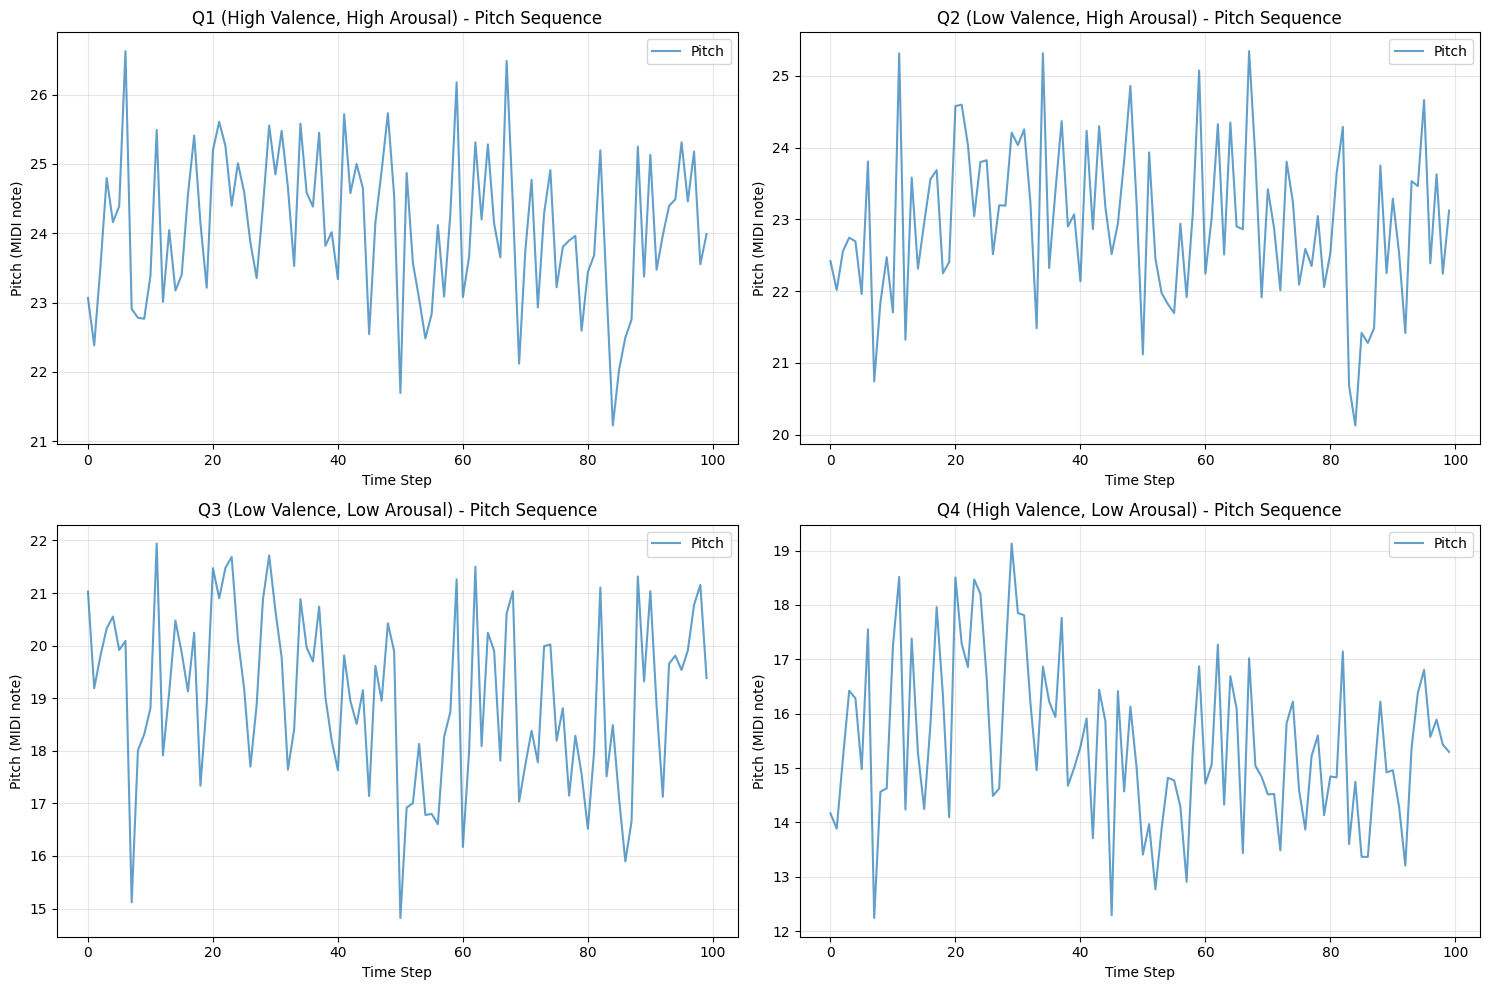

In [13]:
# Visualize generated sequences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (emotion_id, sequence) in enumerate(generated_samples.items()):
    # Plot pitch over time (first 100 notes)
    pitch_seq = sequence[:100, 0] * 87 + 21  # Denormalize pitch (21-108)
    axes[idx].plot(pitch_seq, label='Pitch', alpha=0.7)
    axes[idx].set_title(f'{emotion_names[emotion_id]} - Pitch Sequence')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Pitch (MIDI note)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.show()


In [14]:
# Convert sequence back to MIDI
def sequence_to_midi(sequence, output_path, min_pitch=21, max_pitch=108, tempo=120):
    """
    Convert generated sequence to MIDI file.
    
    Args:
        sequence: Generated sequence array (seq_len, 4)
        output_path: Path to save MIDI file
        min_pitch: Minimum MIDI pitch
        max_pitch: Maximum MIDI pitch
        tempo: Tempo in BPM
    """
    # Create PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)  # Piano
    
    # Denormalize values
    current_time = 0.0
    
    for i, event in enumerate(sequence):
        # Skip if all zeros (padding)
        if np.allclose(event, 0):
            continue
        
        # Denormalize
        pitch = int(event[0] * (max_pitch - min_pitch) + min_pitch)
        velocity = int(event[1] * 127)
        duration = event[2] * 4.0  # Max 4 seconds
        time_offset = event[3] * 2.0  # Max 2 seconds
        
        # Clamp values
        pitch = np.clip(pitch, min_pitch, max_pitch)
        velocity = np.clip(velocity, 20, 127)
        duration = max(0.1, min(duration, 4.0))
        time_offset = max(0.0, min(time_offset, 2.0))
        
        # Create note
        start_time = current_time + time_offset
        end_time = start_time + duration
        
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start_time,
            end=end_time
        )
        piano.notes.append(note)
        
        current_time = start_time
    
    midi.instruments.append(piano)
    
    # Set tempo
    midi.get_tempo_changes()
    midi.write(output_path)
    print(f"MIDI file saved to {output_path}")

# Generate and save MIDI files for each emotion
output_dir = Path('generated_music')
output_dir.mkdir(exist_ok=True)

for emotion_id, sequence in generated_samples.items():
    emotion_name = emotion_names[emotion_id].replace(' ', '_').replace(',', '').replace('(', '').replace(')', '')
    output_path = output_dir / f'generated_emotion_{emotion_id}_{emotion_name}.mid'
    sequence_to_midi(sequence, str(output_path))
    print(f"Generated MIDI for {emotion_names[emotion_id]}: {output_path}")


MIDI file saved to generated_music/generated_emotion_1_Q1_High_Valence_High_Arousal.mid
Generated MIDI for Q1 (High Valence, High Arousal): generated_music/generated_emotion_1_Q1_High_Valence_High_Arousal.mid
MIDI file saved to generated_music/generated_emotion_2_Q2_Low_Valence_High_Arousal.mid
Generated MIDI for Q2 (Low Valence, High Arousal): generated_music/generated_emotion_2_Q2_Low_Valence_High_Arousal.mid
MIDI file saved to generated_music/generated_emotion_3_Q3_Low_Valence_Low_Arousal.mid
Generated MIDI for Q3 (Low Valence, Low Arousal): generated_music/generated_emotion_3_Q3_Low_Valence_Low_Arousal.mid
MIDI file saved to generated_music/generated_emotion_4_Q4_High_Valence_Low_Arousal.mid
Generated MIDI for Q4 (High Valence, Low Arousal): generated_music/generated_emotion_4_Q4_High_Valence_Low_Arousal.mid


## 5. Model Evaluation

Evaluate the model's performance and quality of generated music.


In [15]:
# Evaluation metrics
def evaluate_model(model, dataloader, num_samples=10):
    """Evaluate model on test data"""
    model.eval()
    
    total_vae_loss = 0
    total_trans_loss = 0
    correct_emotion_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for sequences, emotions in dataloader:
            sequences = sequences.to(device)
            emotions = emotions.squeeze().to(device)
            
            # Forward pass
            outputs = model(sequences, emotion_ids=emotions, use_vae=True, use_transformer=True)
            
            # Calculate losses
            vae_loss_val, _, _ = vae_loss(
                outputs['recon'], sequences,
                outputs['mu'], outputs['logvar'],
                beta=0.1
            )
            trans_loss_val = transformer_loss(outputs['transformer_output'], sequences)
            
            total_vae_loss += vae_loss_val.item()
            total_trans_loss += trans_loss_val.item()
            total_samples += sequences.size(0)
            
            if total_samples >= num_samples:
                break
    
    avg_vae_loss = total_vae_loss / min(len(dataloader), num_samples // batch_size + 1)
    avg_trans_loss = total_trans_loss / min(len(dataloader), num_samples // batch_size + 1)
    
    return {
        'vae_loss': avg_vae_loss,
        'transformer_loss': avg_trans_loss,
        'total_loss': avg_vae_loss + avg_trans_loss
    }

# Evaluate if we have data
if emopia_loader is not None:
    print("Evaluating model...")
    metrics = evaluate_model(model, emopia_loader, num_samples=50)
    print("\nEvaluation Metrics:")
    print(f"  VAE Loss: {metrics['vae_loss']:.4f}")
    print(f"  Transformer Loss: {metrics['transformer_loss']:.4f}")
    print(f"  Total Loss: {metrics['total_loss']:.4f}")
else:
    print("No data available for evaluation")


Evaluating model...

Evaluation Metrics:
  VAE Loss: 0.0465
  Transformer Loss: 0.0011
  Total Loss: 0.0477


In [17]:
# Save model

def save_model(model, path):
    """Save model checkpoint (model weights + config).
    Note: Optimizer is phase-specific and not saved here.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': 4,
            'hidden_dim': 256,
            'latent_dim': 128,
            'd_model': 256,
            'nhead': 8,
            'num_transformer_layers': 4,
            'num_lstm_layers': 2,
            'seq_len': 512,
            'num_emotions': 4
        }
    }, path)
    print(f"Model saved to {path}")

# Save the trained model
model_path = 'hybrid_vae_transformer_model.pt'
save_model(model, model_path)

# Load model function (for future use)

def load_model(path, device='cpu'):
    """Load model from checkpoint"""
    checkpoint = torch.load(path, map_location=device)
    config = checkpoint['model_config']
    
    model = HybridVAETransformer(**config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model

print("\nModel saved successfully!")
print("To load the model later, use: model = load_model('hybrid_vae_transformer_model.pt')")


Model saved to hybrid_vae_transformer_model.pt

Model saved successfully!
To load the model later, use: model = load_model('hybrid_vae_transformer_model.pt')


In [18]:
# Improved evaluation: weighted totals + KL/latent stats
import numpy as np

def evaluate_model_v2(model, dataloader, num_samples=50, transformer_weight=TRANSFORMER_LOSS_WEIGHT, beta=VAE_BETA):
    model.eval()
    total_vae_loss = 0.0
    total_trans_loss = 0.0
    total_kl = 0.0
    total_batches = 0
    latent_means = []
    latent_stds = []
    with torch.no_grad():
        for sequences, emotions in dataloader:
            sequences = sequences.to(device)
            emotions = emotions.squeeze().to(device)
            outputs = model(sequences, emotion_ids=emotions, use_vae=True, use_transformer=True)
            vae_loss_val, _, kl_loss = vae_loss(
                outputs['recon'], sequences,
                outputs['mu'], outputs['logvar'],
                beta=beta
            )
            trans_loss_val = transformer_loss(outputs['transformer_output'], sequences)
            total_vae_loss += vae_loss_val.item()
            total_trans_loss += trans_loss_val.item()
            total_kl += kl_loss.item()
            total_batches += 1
            mu = outputs['mu']
            logvar = outputs['logvar']
            latent_means.append(mu.detach().cpu().numpy())
            latent_stds.append((0.5 * logvar).exp().detach().cpu().numpy())
            if total_batches >= max(1, num_samples // batch_size):
                break
    denom = max(1, total_batches)
    avg_vae_loss = total_vae_loss / denom
    avg_trans_loss = total_trans_loss / denom
    avg_kl = total_kl / denom
    if latent_means:
        latent_means = np.concatenate([m.reshape(-1, m.shape[-1]) for m in latent_means], axis=0)
        latent_stds = np.concatenate([s.reshape(-1, s.shape[-1]) for s in latent_stds], axis=0)
        latent_mean_overall = float(latent_means.mean())
        latent_std_overall = float(latent_means.std())
        latent_std_z = float(latent_stds.mean())
    else:
        latent_mean_overall = None
        latent_std_overall = None
        latent_std_z = None
    weighted_total = avg_vae_loss + transformer_weight * avg_trans_loss
    return {
        'vae_loss': avg_vae_loss,
        'transformer_loss': avg_trans_loss,
        'total_loss_unweighted': avg_vae_loss + avg_trans_loss,
        'total_loss_weighted': weighted_total,
        'transformer_weight': transformer_weight,
        'avg_kl': avg_kl,
        'latent_mean_overall': latent_mean_overall,
        'latent_std_overall': latent_std_overall,
        'latent_std_z': latent_std_z
    }

# Run improved evaluation
if emopia_loader is not None:
    print("Evaluating model (v2)...")
    metrics = evaluate_model_v2(model, emopia_loader, num_samples=50)
    print("\nEvaluation Metrics (v2):")
    print(f"  VAE Loss (mean): {metrics['vae_loss']:.6f}")
    print(f"  Transformer Loss (mean): {metrics['transformer_loss']:.6f}")
    print(f"  Total Loss (unweighted): {metrics['total_loss_unweighted']:.6f}")
    print(f"  Total Loss (weighted, training objective): {metrics['total_loss_weighted']:.6f} (transformer_weight={metrics['transformer_weight']})")
    print(f"  Avg KL: {metrics['avg_kl']:.6f}")
    print(f"  Latent mean (overall): {metrics['latent_mean_overall']}, latent std (overall): {metrics['latent_std_overall']}")
    print(f"  Latent z std (from logvar): {metrics['latent_std_z']}")
else:
    print("No data available for evaluation")


Evaluating model (v2)...

Evaluation Metrics (v2):
  VAE Loss (mean): 0.047461
  Transformer Loss (mean): 0.001144
  Total Loss (unweighted): 0.048605
  Total Loss (weighted, training objective): 0.058903 (transformer_weight=10.0)
  Avg KL: 0.000170
  Latent mean (overall): 0.00018646182434167713, latent std (overall): 0.0024515888653695583
  Latent z std (from logvar): 0.9872944355010986


In [19]:
# Optional: small utility to print transformer gradient norm during training

def compute_transformer_grad_norm(model):
    total = 0.0
    count = 0
    for name, p in model.transformer_decoder.named_parameters():
        if p.grad is not None:
            total += p.grad.norm().item()
            count += 1
    return total, count

print("Transformer grad norm helper ready (call inside training loop after backward).")


Transformer grad norm helper ready (call inside training loop after backward).


## Summary

This notebook implements a hybrid VAE-Transformer model for emotion-aware music generation:

1. **Data Loading**: Loads EMOPIA (emotion-labeled) and MAESTRO (unlabeled) MIDI datasets
2. **Preprocessing**: Converts MIDI files to sequences of (pitch, velocity, duration, time_offset)
3. **VAE Encoder-Decoder**: Learns latent representations of music sequences
4. **Transformer Decoder**: Generates sequences conditioned on emotion embeddings
5. **Training**: Two-phase training (pre-train VAE, then fine-tune hybrid model)
6. **Generation**: Generates music sequences for each emotion (Q1-Q4)
7. **MIDI Export**: Converts generated sequences back to MIDI files

### Key Features:
- **Hybrid Architecture**: Combines VAE for representation learning and Transformer for generation
- **Emotion Conditioning**: Uses emotion embeddings (Q1-Q4) to control generation
- **Two-Phase Training**: Pre-trains on unlabeled data, then fine-tunes on emotion-labeled data
- **MIDI Generation**: Outputs playable MIDI files

### Next Steps:
1. Increase training epochs for better quality
2. Experiment with different hyperparameters
3. Add evaluation metrics (FAD, emotion classification accuracy)
4. Deploy as web application (FastAPI + React)
5. Support for longer sequences and polyphonic music
